In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from common import make_data_dict, make_sur_map, make_bin_map, make_sur, myscore, cut_range, clean_parameters
from collections import OrderedDict

sensor_data = make_data_dict()

In [2]:
pre_map =  make_sur_map(sensor_data['S8'][0])
post_map =  make_sur_map(sensor_data['S8'][1])
BINNING_TYPE = '8'
df2 = pd.read_csv("data/bin_map/EllipticIRRAD{}.csv".format(BINNING_TYPE), skiprows=1, names=['col','row','bin'], sep=" ")
bin_map = make_bin_map(df2)
binsize = len(df2['bin'].unique())
pre = pd.merge(sensor_data['S8'][0], df2, on=['col','row'])
post = pd.merge(sensor_data['S8'][1], df2, on=['col','row'])

In [19]:
(bin_map == 7).sum()

135

In [3]:
from common import SuroGen, SuroGen2

/home/mwm/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


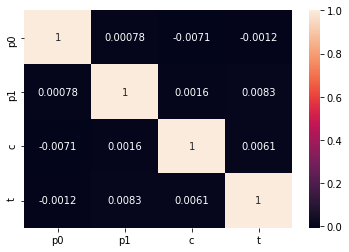

In [4]:
fig, ax = plt.subplots(4,4, figsize=(24,15))

axes = ax[0]
pre_cut = SuroGen.prepare_data(pre)
for m in range(4):
    axes[m].hist(pre_cut.values[:,m],bins=100)
    

GENSIZE = pre.shape[0]
axes = ax[3]
tmpbins = []
for m in range(4):
    _, bins, _  = axes[m].hist(pre_cut.values[:,m],bins=50, label="raw data", alpha=0.5)
    tmpbins.append(bins)
    
axes = ax[2]
sgn = SuroGen()
sgn.fit(pre)
decorelated = sgn.generate_decor(GENSIZE)
_ = axes[0].hist(decorelated[:,0], bins=100, label="original (n={})".format(GENSIZE))
_ = axes[1].hist(decorelated[:,1], bins=100, label="original (n={})".format(GENSIZE))
_ = axes[2].hist(decorelated[:,2], bins=100, label="original (n={})".format(GENSIZE))
_ = axes[3].hist(decorelated[:,3], bins=100, label="original (n={})".format(GENSIZE))

generated = np.zeros_like(decorelated)
axes = ax[1]
_ = axes[0].hist(decorelated[:,0], bins=100, density=True)
_ = axes[1].hist(decorelated[:,1], bins=100, density=True)
_ = axes[2].hist(decorelated[:,2], bins=100, density=True)
_ = axes[3].hist(decorelated[:,3], bins=100, density=True)


EXAMPLE_GENSIZE = 35000
exmpl = sgn.generate_decor(EXAMPLE_GENSIZE)
for j in range(4):
    data = decorelated[:,j]
    params = list(sgn.fit_params.items())[j][1]
    size = 1000 
    x = np.linspace(data.min(), data.max(), size)
    pdf_fitted = sgn.dist.pdf(x, *params) 
    axes = ax[1]
    axes[j].plot(x, pdf_fitted)
    # = dist.rvs(GENSIZE)
    example_gen = exmpl[:,j]
    axes = ax[2]
    axes[j].hist(example_gen, bins=100, label="generated samples (n={})".format(EXAMPLE_GENSIZE))
    axes[j].legend()
    
    
recor = sgn.generate(GENSIZE)
    
axes = ax[3]
for m in range(4):
    axes[m].hist(recor[:,m],bins=tmpbins[m], label="generated", alpha=0.5)
    axes[m].legend()

ax[0,0].set_ylabel("raw data")
ax[1,0].set_ylabel("rescaled and decorelated")
ax[2,0].set_ylabel("rescaled, decoralted and fitted")
ax[3,0].set_ylabel("raw data and generated")
ax[3,0].set_xlabel("p0")
ax[3,1].set_xlabel("p1")
ax[3,2].set_xlabel("c")
ax[3,3].set_xlabel("t")
fig.show()
import seaborn as sns
plt.figure()
corrMatrix = pd.DataFrame(data=decorelated, columns=SuroGen._columns).corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

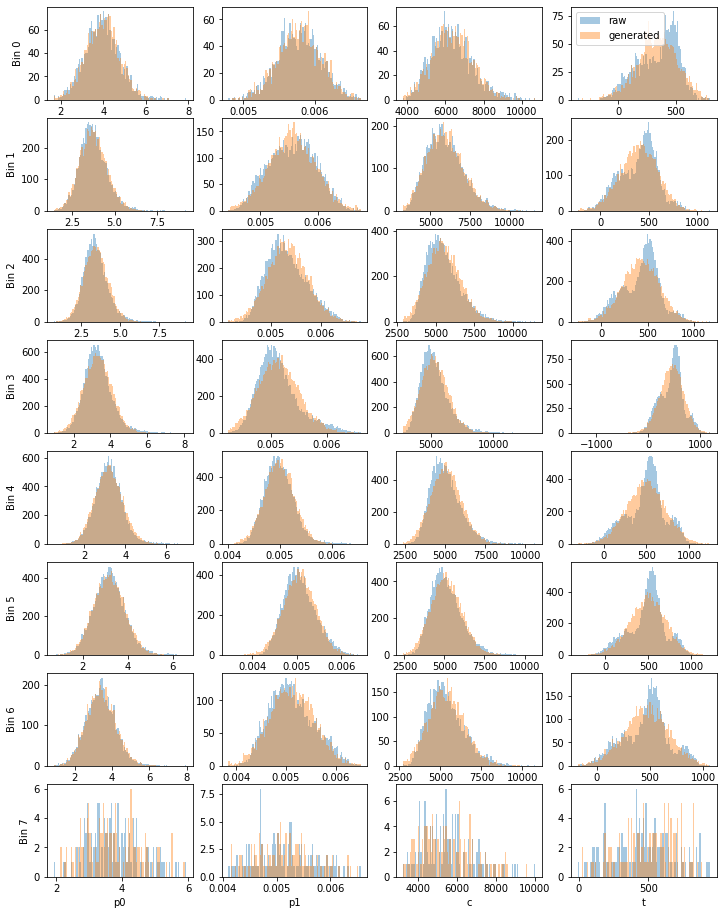

In [5]:
fig, ax = plt.subplots(binsize,4, figsize=(12,16))
genmeans_pre = []
genstd_pre = []
for i, (name, group) in enumerate(pre.groupby('bin')):
    axes = ax[i]
    pre_params = group[['p0','p1','c','t']]
    pre_cut_bin = cut_range(pre_params)
    surogen = SuroGen()
    surogen.fit(group)
    rmi = surogen.means()[0]
    genstd_pre.append(surogen.scaler.scale_)
    genmeans_pre.append(rmi)
    if i == 9:
        generated = group.values
    else:
        generated = surogen.generate(group.shape[0])

    _, b1, _ = axes[0].hist(pre_cut_bin.values[:,0], bins=100, alpha=0.4)
    _, b2, _ = axes[1].hist(pre_cut_bin.values[:,1], bins=100, alpha=0.4)
    _, b3, _ = axes[2].hist(pre_cut_bin.values[:,2], bins=100, alpha=0.4)
    _, b4, _ = axes[3].hist(pre_cut_bin.values[:,3], bins=100, alpha=0.4, label='raw')

    axes[0].hist(generated[:,0], bins=b1, alpha=0.4)
    axes[1].hist(generated[:,1], bins=b2, alpha=0.4)
    axes[2].hist(generated[:,2], bins=b3, alpha=0.4)
    axes[3].hist(generated[:,3], bins=b4, alpha=0.4, label='generated')
    axes[0].set_ylabel("Bin {}".format(name))

axes[0].set_xlabel('p0')
axes[1].set_xlabel('p1')
axes[2].set_xlabel('c')
axes[3].set_xlabel('t')
ax[0,3].legend()




Text(0.5, 141.00000000000014, 't')

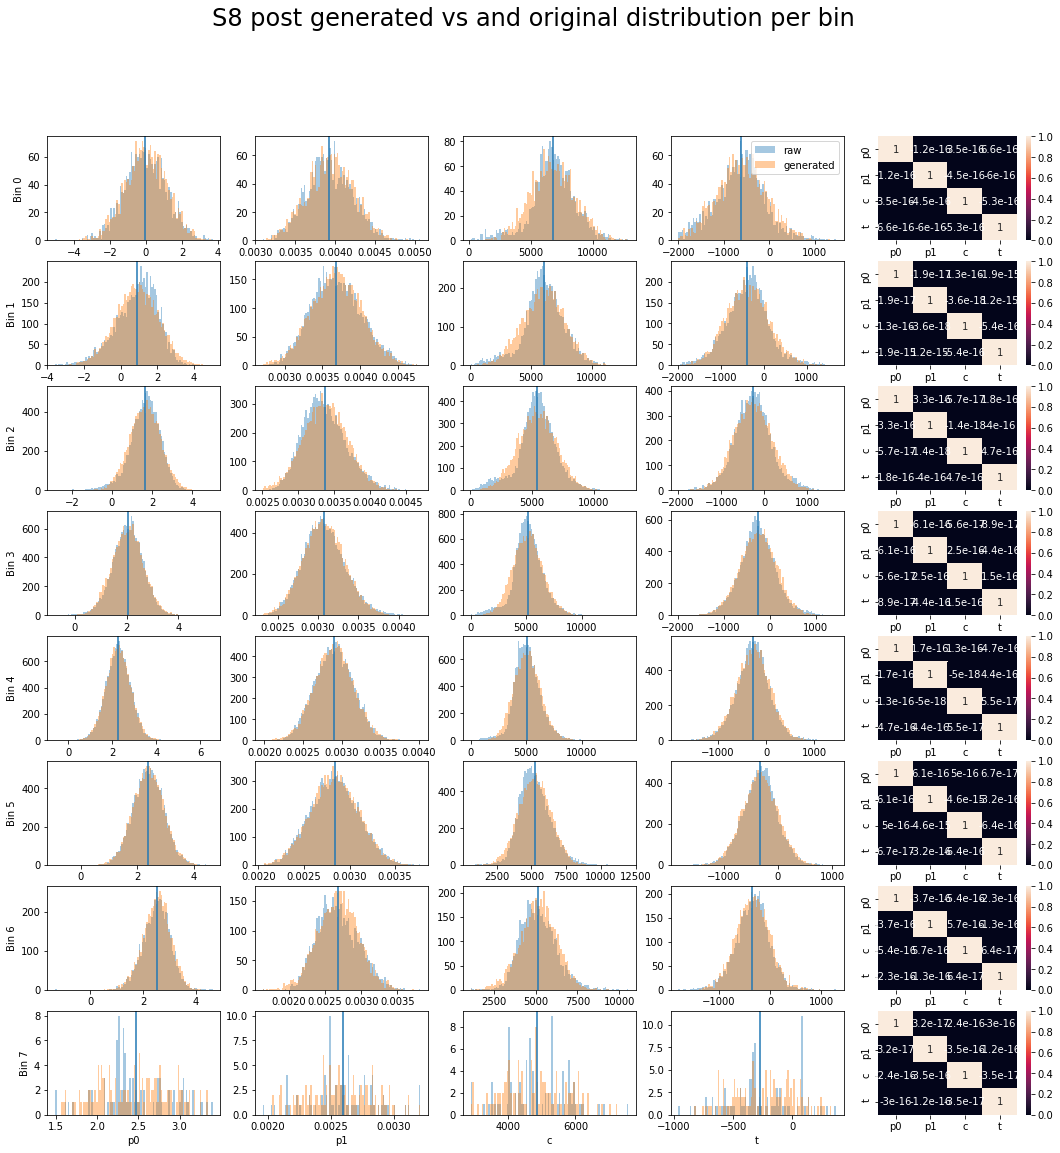

In [6]:
    
fig, ax = plt.subplots(binsize,5, figsize=(18,18))
generated_all = []

genmeans = []
genstd = []
gmeans_dict = {}
surogen_in_bin = {}
corr_in_bin = {}

#generated_to_save_all = {}
#params_in_bin = {}
post_surogen = {}
fig.suptitle("S8 post generated vs and original distribution per bin", fontsize=24)
for i, (name, group) in enumerate(post.groupby('bin')):
    if name==9:
        break
    axes = ax[i]
    pre_params = group[['p0','p1','c','t']]
    pre_cut_bin = cut_range(pre_params)
    surogen = SuroGen()
    surogen.fit(group)
    corr_in_bin[name] = surogen.pca.components_
    generated = surogen.generate(group.shape[0])
    surogen_in_bin[name] = surogen
    generated_all.append(generated)
    rmi = surogen.means()[0]
    genmeans.append(rmi)
    genstd.append(surogen.scaler.scale_)
    gmeans_dict[i] = rmi
    #print([v for v in surogen.fit_params.values()])
    #print(rmi)
    axes[0].axvline(rmi[0])
    axes[1].axvline(rmi[1])
    axes[2].axvline(rmi[2])
    axes[3].axvline(rmi[3])
    
    _, b1, _ = axes[0].hist(pre_cut_bin.values[:,0], bins=100, alpha=0.4)
    _, b2, _ = axes[1].hist(pre_cut_bin.values[:,1], bins=100, alpha=0.4)
    _, b3, _ = axes[2].hist(pre_cut_bin.values[:,2], bins=100, alpha=0.4)
    _, b4, _ = axes[3].hist(pre_cut_bin.values[:,3], bins=100, alpha=0.4, label='raw')

    axes[0].hist(generated[:,0], bins=b1, alpha=0.4)
    axes[1].hist(generated[:,1], bins=b2, alpha=0.4)
    axes[2].hist(generated[:,2], bins=b3, alpha=0.4)
    axes[3].hist(generated[:,3], bins=b4, alpha=0.4, label='generated')
    axes[0].set_ylabel("Bin {}".format(name))
    decorelated = surogen.transform(SuroGen.prepare_data(group))
    corrMatrix = pd.DataFrame(data=decorelated, columns=SuroGen._columns).corr()
    sns.heatmap(corrMatrix, annot=True, ax=axes[4])

ax[0,3].legend()
axes[0].set_xlabel('p0')
axes[1].set_xlabel('p1')
axes[2].set_xlabel('c')
axes[3].set_xlabel('t')



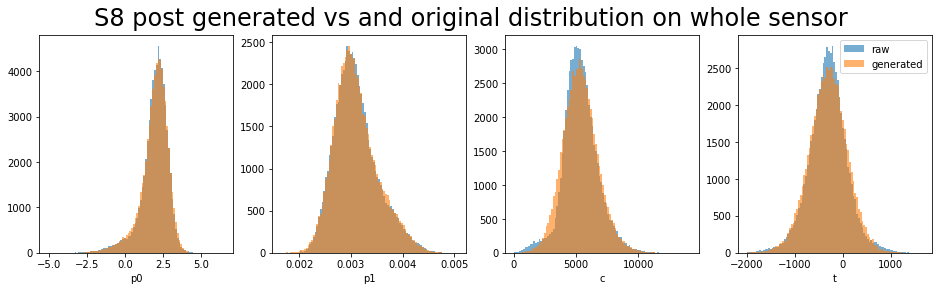

In [7]:
all_gen_arr = np.concatenate(generated_all)
post_cut = post[['p0','p1','c','t']]
post_cut = cut_range(post_cut)

fig, ax = plt.subplots(1,4, figsize=(16,4))
fig.suptitle("S8 post generated vs and original distribution on whole sensor", fontsize=24)
axes = ax
for j in range(4):
    _, b, _ = axes[j].hist(post_cut.values[:,j], bins=100, alpha=0.6, label='raw')
    axes[j].hist(all_gen_arr[:,j], bins=b, alpha=0.6, label='generated')
axes[0].set_xlabel("p0")
axes[1].set_xlabel("p1")
axes[2].set_xlabel("c")
axes[3].set_xlabel("t")
axes[3].legend()

In [8]:
#plt.style.use("bmh")
fig, axes = plt.subplots(1,1,figsize=(18,8), sharey=True)
max_tp_charge = 8000
x = np.linspace(900, max_tp_charge, 100)
p0_range=(-10,10)
p1_range=(0,0.010)
c_range=(0,15000)
t_range=(-2000,3000)
axe = axes
fig.suptitle("Original (n=300) and generated (n=300) surrogates S8 pre - generated for whole sensor", fontsize=16)
sampled_pre = pre_cut.sample(300)
for i,row in sampled_pre.iterrows():
    sur = make_sur(row['p0'], row['p1'], row['c'], row['t'])
    xfilt = x[x>row['t']]
    y = sur(xfilt)
    xfilt = xfilt[y>-50]
    y = y[y>-50]
    axe.plot(xfilt,y, color='blue', alpha=0.2)

axe.plot(xfilt,y, color='blue', alpha=0.2, label='original')
recor_sampled = pd.DataFrame(data=recor, index=None, columns=['p0','p1','c','t']).sample(300) 
for i,row in recor_sampled.iterrows():
    sur = make_sur(row['p0'], row['p1'], row['c'], row['t'])
    xfilt = x[x>row['t']]
    y = sur(xfilt)
    xfilt = xfilt[y>-50]
    y = y[y>-50]
    axe.plot(xfilt,y, color='orange', alpha=0.2)
    
axe.plot(xfilt,y, color='orange', alpha=0.2, label='generated')
axe.legend(prop={'size': 10})

In [9]:
#plt.style.use("bmh")
fig, axes = plt.subplots(1,1,figsize=(18,8), sharey=True)
max_tp_charge = 8000
x = np.linspace(900, max_tp_charge, 100)
p0_range=(-10,10)
p1_range=(0,0.010)
c_range=(0,15000)
t_range=(-2000,3000)
axe = axes
fig.suptitle("Original (n=300) and generated (n=300) surrogates, S8 post - generated per bin", fontsize=16)
sampled_pre = post_cut.sample(300)
for i,row in sampled_pre.iterrows():
    sur = make_sur(row['p0'], row['p1'], row['c'], row['t'])
    xfilt = x[x>row['t']]
    y = sur(xfilt)
    xfilt = xfilt[y>-50]
    y = y[y>-50]
    axe.plot(xfilt,y, color='blue', alpha=0.2)

axe.plot(xfilt,y, color='blue', alpha=0.2, label='original')
recor_sampled = pd.DataFrame(data=all_gen_arr, index=None, columns=['p0','p1','c','t']).sample(300) 
for i,row in recor_sampled.iterrows():
    sur = make_sur(row['p0'], row['p1'], row['c'], row['t'])
    xfilt = x[x>row['t']]
    y = sur(xfilt)
    xfilt = xfilt[y>-50]
    y = y[y>-50]
    axe.plot(xfilt,y, color='orange', alpha=0.2)
    
axe.plot(xfilt,y, color='orange', alpha=0.2, label='generated')
axe.legend(prop={'size': 10})

In [10]:

genmeans

[array([-3.11777986e-02,  3.92693992e-03,  6.75693767e+03, -6.30463862e+02]),
 array([ 8.76939952e-01,  3.68481748e-03,  6.03346669e+03, -3.84760320e+02]),
 array([ 1.63981591e+00,  3.36718455e-03,  5.39970412e+03, -2.60212614e+02]),
 array([ 2.04000412e+00,  3.07407791e-03,  5.16752558e+03, -2.60087489e+02]),
 array([ 2.27259539e+00,  2.90010576e-03,  5.11156406e+03, -2.72657849e+02]),
 array([ 2.39487727e+00,  2.83584875e-03,  5.26107708e+03, -3.34124982e+02]),
 array([ 2.50789034e+00,  2.68109381e-03,  5.17423893e+03, -3.43652248e+02]),
 array([ 2.47454396e+00,  2.59590443e-03,  4.84875005e+03, -2.72300652e+02])]

In [11]:
#plt.style.use("bmh")
fig, axes = plt.subplots(1,1,figsize=(18,8), sharey=True)
max_tp_charge = 8000
x = np.linspace(900, max_tp_charge, 100)
p0_range=(-10,10)
p1_range=(0,0.010)
c_range=(0,15000)
t_range=(-2000,3000)
axe = axes
fig.suptitle("Original (n=300) and generated (n=7) surrogates, S8 post - generated per bin", fontsize=16)
sampled_pre = post_cut.sample(300)
for i,row in sampled_pre.iterrows():
    break
    sur = make_sur(row['p0'], row['p1'], row['c'], row['t'])
    xfilt = x[x>row['t']]
    y = sur(xfilt)
    xfilt = xfilt[y>-50]
    y = y[y>-50]
    axe.plot(xfilt,y, color='blue', alpha=0.2)

axe.plot(xfilt,y, color='blue', alpha=0.2, label='original')
recor_sampled = pd.DataFrame(data=genmeans, index=None, columns=['p0','p1','c','t'])
recor_sampled_std = pd.DataFrame(data=genstd, index=None, columns=['p0','p1','c','t'])
for i,row in recor_sampled.iterrows():
    sur = make_sur(row['p0'], row['p1'], row['c'], row['t'])
    xfilt = x[x>row['t']]
    y = sur(xfilt)
    xfilt = xfilt[y>-50]
    y = y[y>-50]
    axe.plot(xfilt,y, label=str(i))
    
axe.plot(xfilt,y, color='orange', alpha=0.2, label='generated')
axe.legend(prop={'size': 10})

In [12]:
import matplotlib; print(matplotlib. __version__)

3.3.1


In [13]:
from scipy.optimize import curve_fit


fig,axes = plt.subplots(1,4, figsize=(16,4))
for i, p in enumerate(SuroGen._columns):
    print(recor_sampled[p].values)
    print(recor_sampled_std[p].values)
    axes[i].plot(range(8), recor_sampled[p].values, label=p)
    (_, caps, _) = axes[i].errorbar(range(8), recor_sampled[p].values, yerr=recor_sampled_std[p].values, label=p, fmt='.k', capsize=3 )
    for cap in caps:
        cap.set_markeredgewidth(1)
    
    zfit = np.polyfit(range(8),recor_sampled[p],3)
    poly = np.poly1d(zfit)
    axes[i].plot(range(8), poly(range(8)))

    axes[i].set_xlabel(p)
    axes[0].set_ylabel("Vs bin")
    axes[0].set_ylabel("Vs bin fluence")

[-0.0311778   0.87693995  1.63981591  2.04000412  2.27259539  2.39487727
  2.50789034  2.47454396]
[1.15246129 1.14431089 0.77064729 0.59727085 0.55448282 0.53621902
 0.51314553 0.4161193 ]
[0.00392694 0.00368482 0.00336718 0.00307408 0.00290011 0.00283585
 0.00268109 0.0025959 ]
[0.0002892  0.00032937 0.00030267 0.00026265 0.00024646 0.00026249
 0.00028136 0.00026758]
[6756.9376674  6033.46668825 5399.70411565 5167.5255841  5111.56406004
 5261.0770838  5174.23893325 4848.75004811]
[1807.27063662 1715.30041407 1570.52094865 1358.67832819 1198.91302782
 1150.75687819 1082.81460916  927.82160449]
[-630.46386223 -384.7603201  -260.21261402 -260.08748936 -272.65784908
 -334.12498219 -343.65224797 -272.30065228]
[545.67049361 501.27406476 440.34590061 393.96483717 350.25724234
 323.4176215  325.27614276 279.70633812]


[1.15246129 1.14431089 0.77064729 0.59727085 0.55448282 0.53621902
 0.51314553 0.4161193 ]
[0.0002892  0.00032937 0.00030267 0.00026265 0.00024646 0.00026249
 0.00028136 0.00026758]
[1807.27063662 1715.30041407 1570.52094865 1358.67832819 1198.91302782
 1150.75687819 1082.81460916  927.82160449]
[545.67049361 501.27406476 440.34590061 393.96483717 350.25724234
 323.4176215  325.27614276 279.70633812]


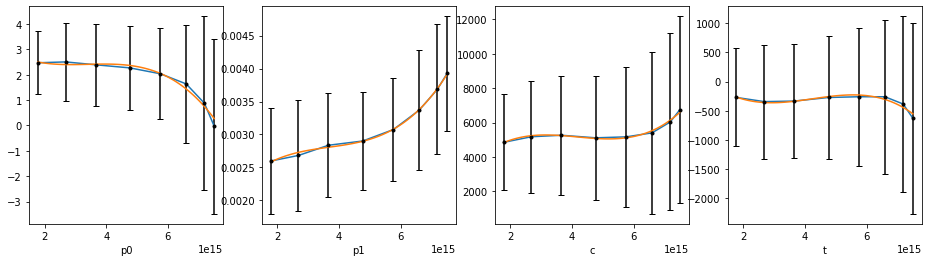

In [14]:
from scipy.optimize import curve_fit

bin_8_fluences = [
7.504e+15 ,
7.187e+15,
6.595e+15,
5.76e+15,
4.766e+15,
3.655e+15,
2.681e+15,
1.779e+15 ,
]

fig,axes = plt.subplots(1,4, figsize=(16,4))
for i, p in enumerate(SuroGen._columns):
    print(recor_sampled_std[p].values)
    axes[i].plot( bin_8_fluences,recor_sampled[p].values, label=p)
    (_, caps, _) = axes[i].errorbar(bin_8_fluences, recor_sampled[p].values, yerr=3*recor_sampled_std[p].values, label=p, fmt='.k', capsize=3 )

    fitrange = np.linspace(min(bin_8_fluences), max(bin_8_fluences), 100)
    zfit = np.polyfit(bin_8_fluences,recor_sampled[p],3, w=1/recor_sampled_std[p])
    poly = np.poly1d(zfit)
    axes[i].plot(fitrange, poly(fitrange))
    axes[i].set_xlabel(p)

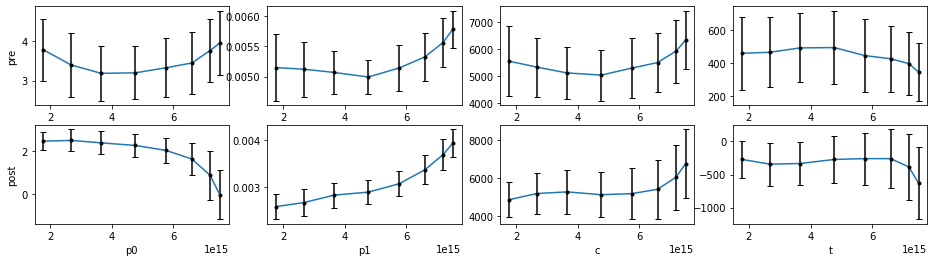

In [16]:
from scipy.optimize import curve_fit


recor_sampled_pre = pd.DataFrame(data=genmeans_pre, index=None, columns=['p0','p1','c','t'])
recor_sampled_std_pre = pd.DataFrame(data=genstd_pre, index=None, columns=['p0','p1','c','t'])
for i,row in recor_sampled_pre.iterrows():
    sur = make_sur(row['p0'], row['p1'], row['c'], row['t'])
    xfilt = x[x>row['t']]
    y = sur(xfilt)
    xfilt = xfilt[y>-50]
    y = y[y>-50]

bin_8_fluences = [
7.504e+15 ,
7.187e+15,
6.595e+15,
5.76e+15,
4.766e+15,
3.655e+15,
2.681e+15,
1.779e+15 ,
]

fig,axes = plt.subplots(2,4, figsize=(16,4))
for i, p in enumerate(SuroGen._columns):
    axes[0][i].plot(bin_8_fluences, recor_sampled_pre[p].values)
    axes[1][i].plot(bin_8_fluences, recor_sampled[p].values)
    (_, caps, _) = axes[1][i].errorbar(bin_8_fluences, recor_sampled[p].values, yerr=recor_sampled_std[p].values, label=p, fmt='.k', capsize=3 )
    (_, caps, _) = axes[0][i].errorbar(bin_8_fluences, recor_sampled_pre[p].values, yerr=recor_sampled_std_pre[p].values, label=p, fmt='.k', capsize=3 )
    diff = recor_sampled[p].values - recor_sampled_pre[p].values
    axes[1][i].set_xlabel(p)
    axes[0][0].set_ylabel('pre')
    axes[1][0].set_ylabel('post')
    #axes[2][i].plot( bin_8_fluences,diff, label=p)
    #zfit = np.polyfit(bin_8_fluences,diff,3)
    #poly = np.poly1d(zfit)
    #axes[2][i].plot(bin_8_fluences, poly(bin_8_fluences))

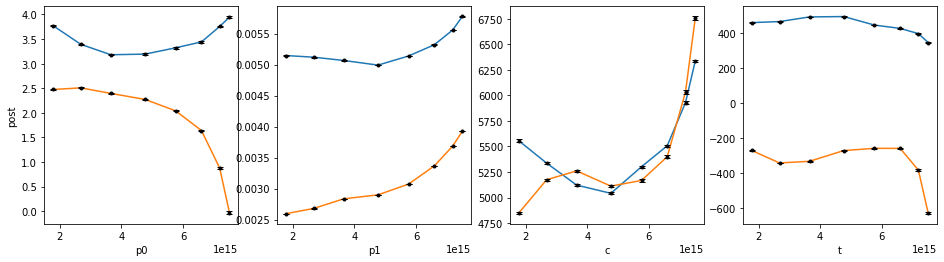

In [28]:
from scipy.optimize import curve_fit


recor_sampled_pre = pd.DataFrame(data=genmeans_pre, index=None, columns=['p0','p1','c','t'])
recor_sampled_std_pre = pd.DataFrame(data=genstd_pre, index=None, columns=['p0','p1','c','t'])
for i,row in recor_sampled_pre.iterrows():
    sur = make_sur(row['p0'], row['p1'], row['c'], row['t'])
    xfilt = x[x>row['t']]
    y = sur(xfilt)
    xfilt = xfilt[y>-50]
    y = y[y>-50]

bin_8_fluences = [
7.504e+15 ,
7.187e+15,
6.595e+15,
5.76e+15,
4.766e+15,
3.655e+15,
2.681e+15,
1.779e+15 ,
]

fig,axes = plt.subplots(1,4, figsize=(16,4))
for i, p in enumerate(SuroGen._columns):
    s = (bin_map == i).sum()
    axes[i].plot(bin_8_fluences, recor_sampled_pre[p].values)
    axes[i].plot(bin_8_fluences, recor_sampled[p].values)
    (_, caps, _) = axes[i].errorbar(bin_8_fluences, recor_sampled[p].values, yerr=recor_sampled_std[p].values/np.sqrt(s), label=p, fmt='.k', capsize=3 )
    (_, caps, _) = axes[i].errorbar(bin_8_fluences, recor_sampled_pre[p].values, yerr=recor_sampled_std_pre[p].values/np.sqrt(s), label=p, fmt='.k', capsize=3 )
    diff = recor_sampled[p].values - recor_sampled_pre[p].values
    axes[i].set_xlabel(p)
    axes[0].set_ylabel('pre')
    axes[0].set_ylabel('post')
    #axes[2][i].plot( bin_8_fluences,diff, label=p)
    #zfit = np.polyfit(bin_8_fluences,diff,3)
    #poly = np.poly1d(zfit)
    #axes[2][i].plot(bin_8_fluences, poly(bin_8_fluences))